In [1]:
import logging
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sif.siftools.backtesters import full_backtesters as fb
from sif.siftools.abstractalpha import AbstractAlpha
from sif.siftools import operators as op
from sif.siftools import metrics
from IPython.core import display as ICD
plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
show_logs = False # Set this to False if you do not want the logs to be shown
logger = None
if show_logs:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

In [3]:
# backtester = fb.FullSingleBacktester(
#     start_date=datetime.datetime(year=2014, month=1, day=1),
#     end_date=datetime.datetime(year=2017, month=1, day=1),
#     universe_rebalance_dates=[(1, 1), (4, 1), (7, 1), (10, 1)],
#     max_lookback=252,
#     universe_size=500,
#     factors=['revenueusd', 'industry', 'close', 'assets', 'sgna']
# )

# Uncomment to save backtester for later usage
# backtester.save_local('full_demo_data.npy')

# Alternatively, if you have previously saved the backtester, uncomment the
# code below and insert the path to the '.npy' file it is saved as

backtester = fb.FullSingleBacktester.from_local('full_demo_data.npy')

In [8]:
%pip install pandas_ta
import pandas_ta as ta
import numpy as np
class StochasticAverages(AbstractAlpha):
    def __init__(self):
        super(StochasticAverages, self).__init__()
        self.name = 'Stochastic Averages'
        self.factor_list = ['open', 'high', 'low', 'close']  # Include all needed factors
        self.lookback = 30  # Adjust based on the longest period required by the indicators
        self.universe_size = 500  # Total universe size
    def generate_day(self, day, data):
        weights = np.zeros(self.universe_size)
        for i in range(self.universe_size):
            # Check if the stock index is within bounds
            df = data['close']
            if i >= df.shape[0]:
                continue
            # Extracting price data for each stock
            # open_prices = pd.Series(data['open'][i, :])
            high_prices = pd.Series(data['high'][i, :])
            low_prices = pd.Series(data['low'][i, :])
            close_prices = pd.Series(data['close'][i, :])
            stochastic = ta.stoch(high=high_prices, low=low_prices, close=close_prices, k=14, d=3) if len(close_prices) >= 14 else None
            if stochastic is None:
                continue

            sma = df[i].sum() /(self.lookback + 1)
            ema = df[i][0]
            smoothing = 2 / (self.lookback + 2)
            for j in range(1, self.lookback):
                ema = smoothing * df[i][j] + (1 - smoothing) * ema

            # Trading signals based on MACD, RSI, and Stochastic
            buy_signal = (stochastic['STOCHk_14_3_3'].iloc[-1] < 50)
            sell_signal = (stochastic['STOCHk_14_3_3'].iloc[-1] > 55)
            # Only buy if EMA < SMA to find stocks with most potential for gain
            if buy_signal:
                weights[i] = max(0, sma - ema)
            elif sell_signal:
                weights[i] = -1
        # Normalize weights across the universe
        total_weight = np.sum(np.abs(weights))
        if total_weight > 0:
            weights /= total_weight
        return weights

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
returns, holdings = backtester.backtest(StochasticAverages(), use_env_universe=False)

2015-12-31 00:00:00: 100%|██████████| 1510/1510 [01:27<00:00, 17.32it/s]


0.3770041479042474


<AxesSubplot:>

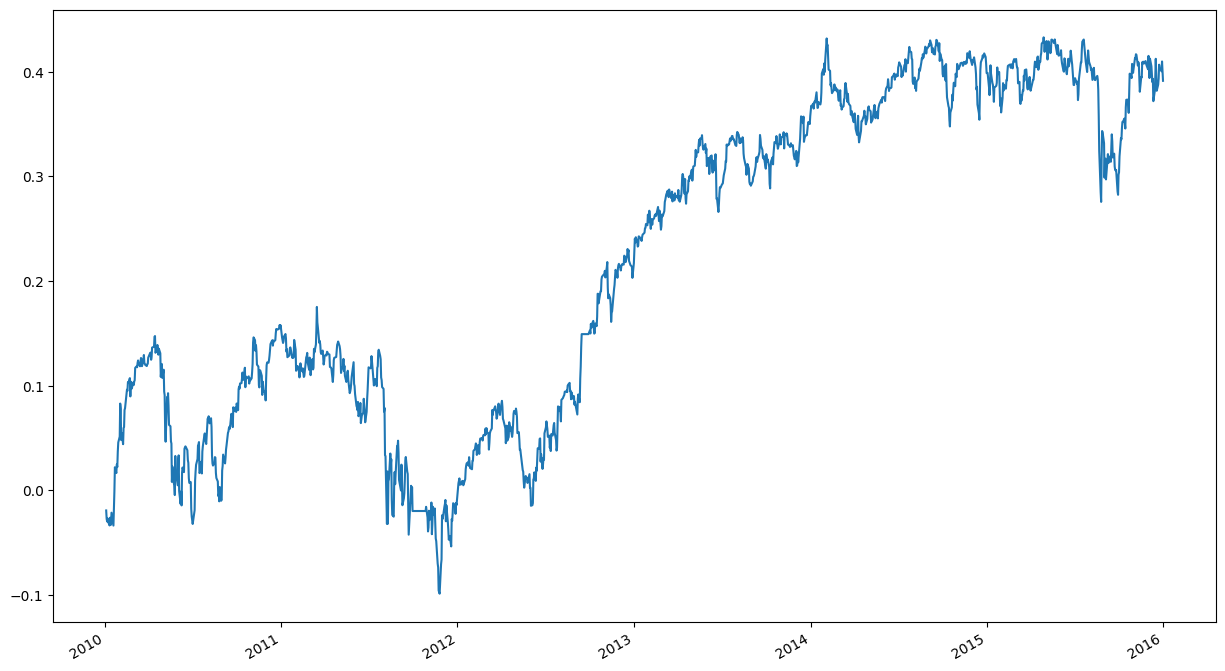

In [10]:
total_return = np.prod(1 + returns) - 1
print(total_return)
returns.cumsum().plot()

In [11]:
# Assuming returns and holdings are defined earlier in your code
perf_tables = metrics.generate_performance_table(returns, holdings)
ICD.display(perf_tables)

C:\Users\rajat\sif\sif\siftools\metrics.py:198: RuntimeWarning: invalid value encountered in greater
  long_counts = (arr > 0).sum(axis=1)
C:\Users\rajat\sif\sif\siftools\metrics.py:214: RuntimeWarning: invalid value encountered in less
  short_counts = (arr < 0).sum(axis=1)
C:\Users\rajat\AppData\Local\Temp\ipykernel_10516\2451407978.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  ICD.display(perf_tables)


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2010,0.157638,0.878668,1.249080,0.170251,0.143229,26.253968,2.456349
2011,-0.171815,-0.826551,-1.052395,0.252969,0.035925,20.190476,7.626984
2012,0.231256,1.864692,3.030455,0.096682,0.449717,21.404000,0.000000
2013,0.140653,1.218742,1.699133,0.071920,0.268473,24.841270,1.571429
2014,0.040992,0.364926,0.565952,0.095651,0.005088,24.496032,7.480159
2015,-0.007326,-0.045934,-0.067937,0.148721,0.006672,32.000000,0.000000
Overall,0.391398,0.423290,0.575132,0.252969,0.160014,24.868874,3.193377
